In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error



# Generacion de datos


In [95]:
def generate_complex_data(n_samples=1000, n_useful=5, n_noisy=5):
    """
    Generates data based on a more complex function.
    
    Parameters:
    - n_samples: Number of samples.
    - n_useful: Number of useful features.
    - n_noisy: Number of noisy features.
    
    Returns:
    - X: Feature matrix.
    - y: Target variable.
    """
    X = np.random.rand(n_samples, n_useful)
    y = np.zeros(n_samples)
    
    # Useful features generation
    for i in range(n_useful):
        if i % 5 == 0:
            y += X[:, i]**3 * np.sin(X[:, (i + 1) % n_useful]**2)
        elif i % 5 == 1:
            y += np.exp(X[:, i])
        elif i % 5 == 2:
            y += X[:, i] * np.log(X[:, (i + 1) % n_useful] + 1)
        elif i % 5 == 3:
            y += X[:, i] * X[:, (i + 1) % n_useful]
        else:
            y += X[:, i]**2.5
    
    # Add strong noise to the target variable
    y += np.random.normal(0, 2, n_samples)
    
    # Noisy features
    noisy_features = np.random.randn(n_samples, n_noisy) * 10  # Here, the variance is increased by scaling
    
    X = np.column_stack([X, noisy_features])
    
    return X, y


# CV

In [96]:
def lasso_regression(X, y, alpha):
    model = Lasso(alpha=alpha)
    model.fit(X, y)
    return model

In [97]:
def cross_val_error(X_train, y_train, X_test, y_test, alpha, cv=5):
    """
    Computes the cross-validation error, test error, 
    and standard deviations.
    
    Parameters:
    - X_train: Training feature matrix.
    - y_train: Training target variable.
    - X_test: Test feature matrix.
    - y_test: Test target variable.
    - alpha: Regularization strength for Lasso.
    - cv: Number of cross-validation folds.
    
    Returns:
    - train_error_mean: Mean train error.
    - train_error_std: Standard deviation of train error.
    - val_error_mean: Mean validation error.
    - val_error_std: Standard deviation of validation error.
    - test_error: Test error for the provided alpha.
    - coeffs_mean: Mean coefficients.
    - coeffs_std: Standard deviation of coefficients.
    """
    kf = KFold(n_splits=cv)
    train_errors = []
    val_errors = []
    test_errors = []  # List for storing test errors of each fold model
    coeffs = []
    
    for train_index, val_index in kf.split(X_train):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]
        
        lasso = Lasso(alpha=alpha, max_iter=1000)
        lasso.fit(X_tr, y_tr)
        
        y_train_pred = lasso.predict(X_tr)
        y_val_pred = lasso.predict(X_val)
        
        y_test_pred = lasso.predict(X_test)  # Predict on test set
        test_errors.append(mean_squared_error(y_test, y_test_pred))
        
        train_errors.append(mean_squared_error(y_tr, y_train_pred))
        val_errors.append(mean_squared_error(y_val, y_val_pred))
        coeffs.append(lasso.coef_)
    
    coeffs = np.array(coeffs)
    
    return (
        np.mean(train_errors), 
        np.std(train_errors),
        np.mean(val_errors),
        np.std(val_errors),
        np.mean(test_errors),  # Average test error across models
        np.mean(coeffs, axis=0),
        np.std(coeffs, axis=0)
    )


# Analisis descriptivo de los errors

In [98]:
def plot_errors(alphas, train_errors, train_stds, val_errors, val_stds, test_errors):
    plt.figure(figsize=(15, 6))
    
    # Train and validation errors
    plt.errorbar(alphas, train_errors, yerr=train_stds, label="Train Error", capsize=5)
    plt.errorbar(alphas, val_errors, yerr=val_stds, label="CV Error", capsize=5)
    
    # Test errors
    plt.plot(alphas, test_errors, label="Test Error", linestyle='-.')
    
    min_alpha_index = np.argmin(val_errors)
    min_test_alpha_index = np.argmin(test_errors)
    plt.axvline(alphas[min_alpha_index], linestyle='--', color='gray', label=f'Min CV Error at Alpha: {alphas[min_alpha_index]:.5f}')
    plt.axvline(alphas[min_test_alpha_index], linestyle=':', color='blue', label=f'Min Test Error at Alpha: {alphas[min_test_alpha_index]:.5f}')
    
    plt.xscale('log')
    plt.xlabel("Alpha (Regularization Strength)")
    plt.ylabel("Mean Squared Error")
    plt.title("Error vs. Alpha")
    plt.legend()
    plt.show()



def plot_avg_cv_error(alphas, val_errors, test_errors):
    plt.figure(figsize=(10, 6))
    plt.plot(alphas, val_errors, label="Average CV Error", linestyle='-')
    plt.xscale('log')
    plt.xlabel("Alpha (Regularization Strength)")
    plt.ylabel("Average Mean Squared Error")
    
    # Add vertical line for minimum validation error
    min_val_error_alpha = alphas[np.argmin(val_errors)]
    plt.axvline(min_val_error_alpha, linestyle='-.', color='r', label=f"Min CV Error at Alpha: {min_val_error_alpha:.2e}")
    min_test_alpha_index = np.argmin(test_errors)
    plt.axvline(alphas[min_test_alpha_index], linestyle=':', color='blue', label=f'Min Test Error at Alpha: {alphas[min_test_alpha_index]:.5f}')
    
    
    plt.legend()
    plt.title("Average CV Error vs. Alpha for Lasso Regression")
    plt.show()

def plot_error_std(alphas, val_stds, test_errors):
    plt.figure(figsize=(10, 6))
    plt.plot(alphas, val_stds, label="CV Error Standard Deviation", linestyle='-')
    plt.xscale('log')
    plt.xlabel("Alpha (Regularization Strength)")
    plt.ylabel("Standard Deviation of Error")
    
    # Add vertical line for minimum error standard deviation
    min_val_std_alpha = alphas[np.argmin(val_stds)]
    plt.axvline(min_val_std_alpha, linestyle='-.', color='r', label=f"Min CV Error Std at Alpha: {min_val_std_alpha:.2e}")
    min_test_alpha_index = np.argmin(test_errors)
    plt.axvline(alphas[min_test_alpha_index], linestyle=':', color='blue', label=f'Min Test Error at Alpha: {alphas[min_test_alpha_index]:.5f}')
    
    plt.legend()
    plt.title("CV Error Standard Deviation vs. Alpha for Lasso Regression")
    plt.show()


def display_error_table(alphas, train_errors, train_stds, val_errors, val_stds):
    df = pd.DataFrame({
        'Alpha': alphas,
        'Train Error': train_errors,
        'Train Error Std': train_stds,
        'Validation Error': val_errors,
        'Validation Error Std': val_stds
    })

    return df

In [99]:
# Analisis descriptivo de los coeficientes

# Laboratorio

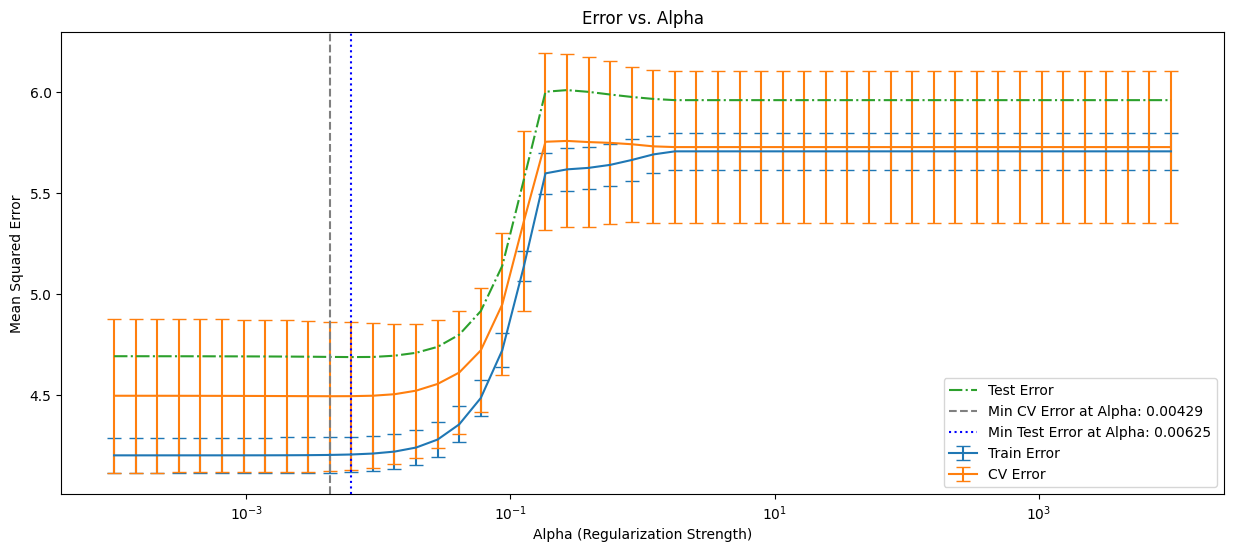

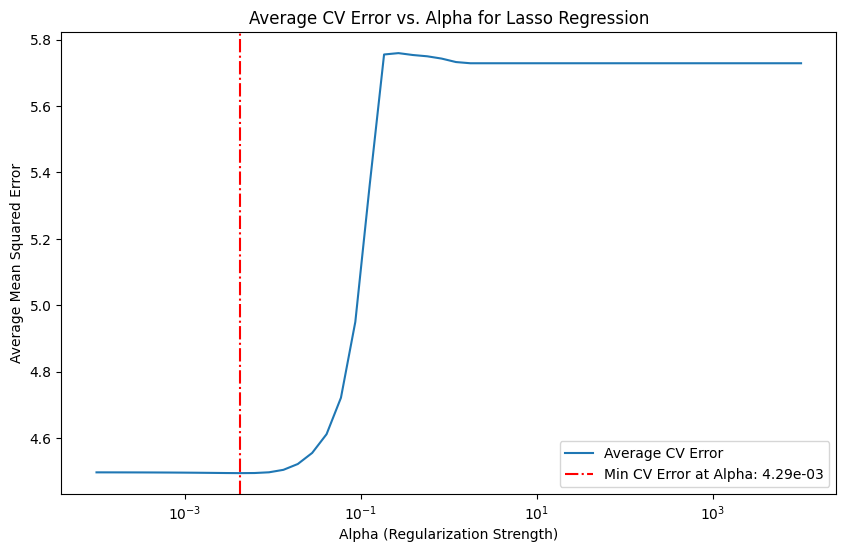

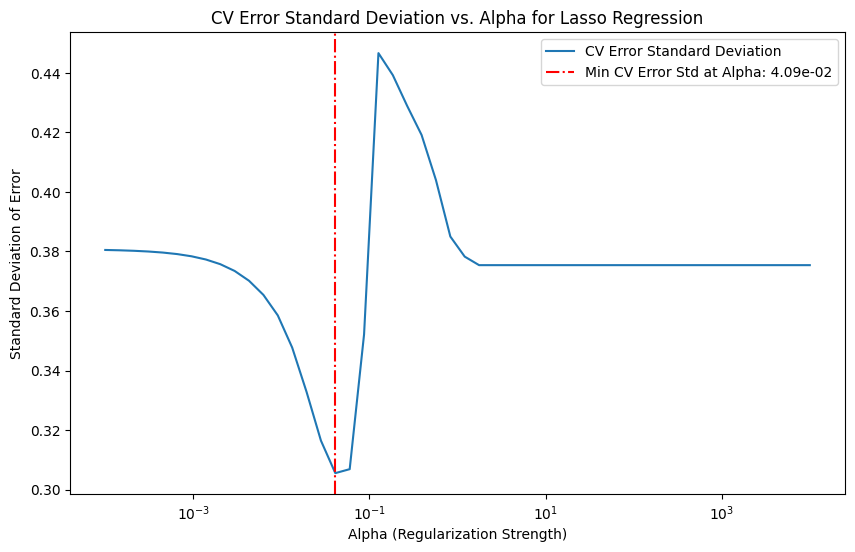

In [113]:
np.random.seed(442)
n_useful = 10
n_noisy = 10
# 1. Generar Datos con 8 características útiles y 5 ruidosas
X, y = generate_complex_data(n_samples=1000, n_useful=n_useful, n_noisy=n_noisy)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=442)

# 2. Configurar valores de Alpha
alphas = np.logspace(-4, 4, 50)

# 3. Calcular errores y coeficientes para cada Alpha
train_errors = []
train_stds = []
val_errors = []
val_stds = []
test_errors = []
coeffs_mean = []
coeffs_std = []

for alpha in alphas:
    train_error, train_std, val_error, val_std, test_error, coeff_mean, coeff_std = cross_val_error(X_train, y_train, X_test, y_test, alpha)
    train_errors.append(train_error)
    train_stds.append(train_std)
    val_errors.append(val_error)
    val_stds.append(val_std)
    test_errors.append(test_error)
    coeffs_mean.append(coeff_mean)
    coeffs_std.append(coeff_std)

# 4. Graficar los errores
plot_errors(alphas, train_errors, train_stds, val_errors, val_stds, test_errors)


# 5. Plot Average CV Error
plot_avg_cv_error(alphas, val_errors, test_errors=test_errors)

# 6. Plot Error Standard Deviation
plot_error_std(alphas, val_stds)



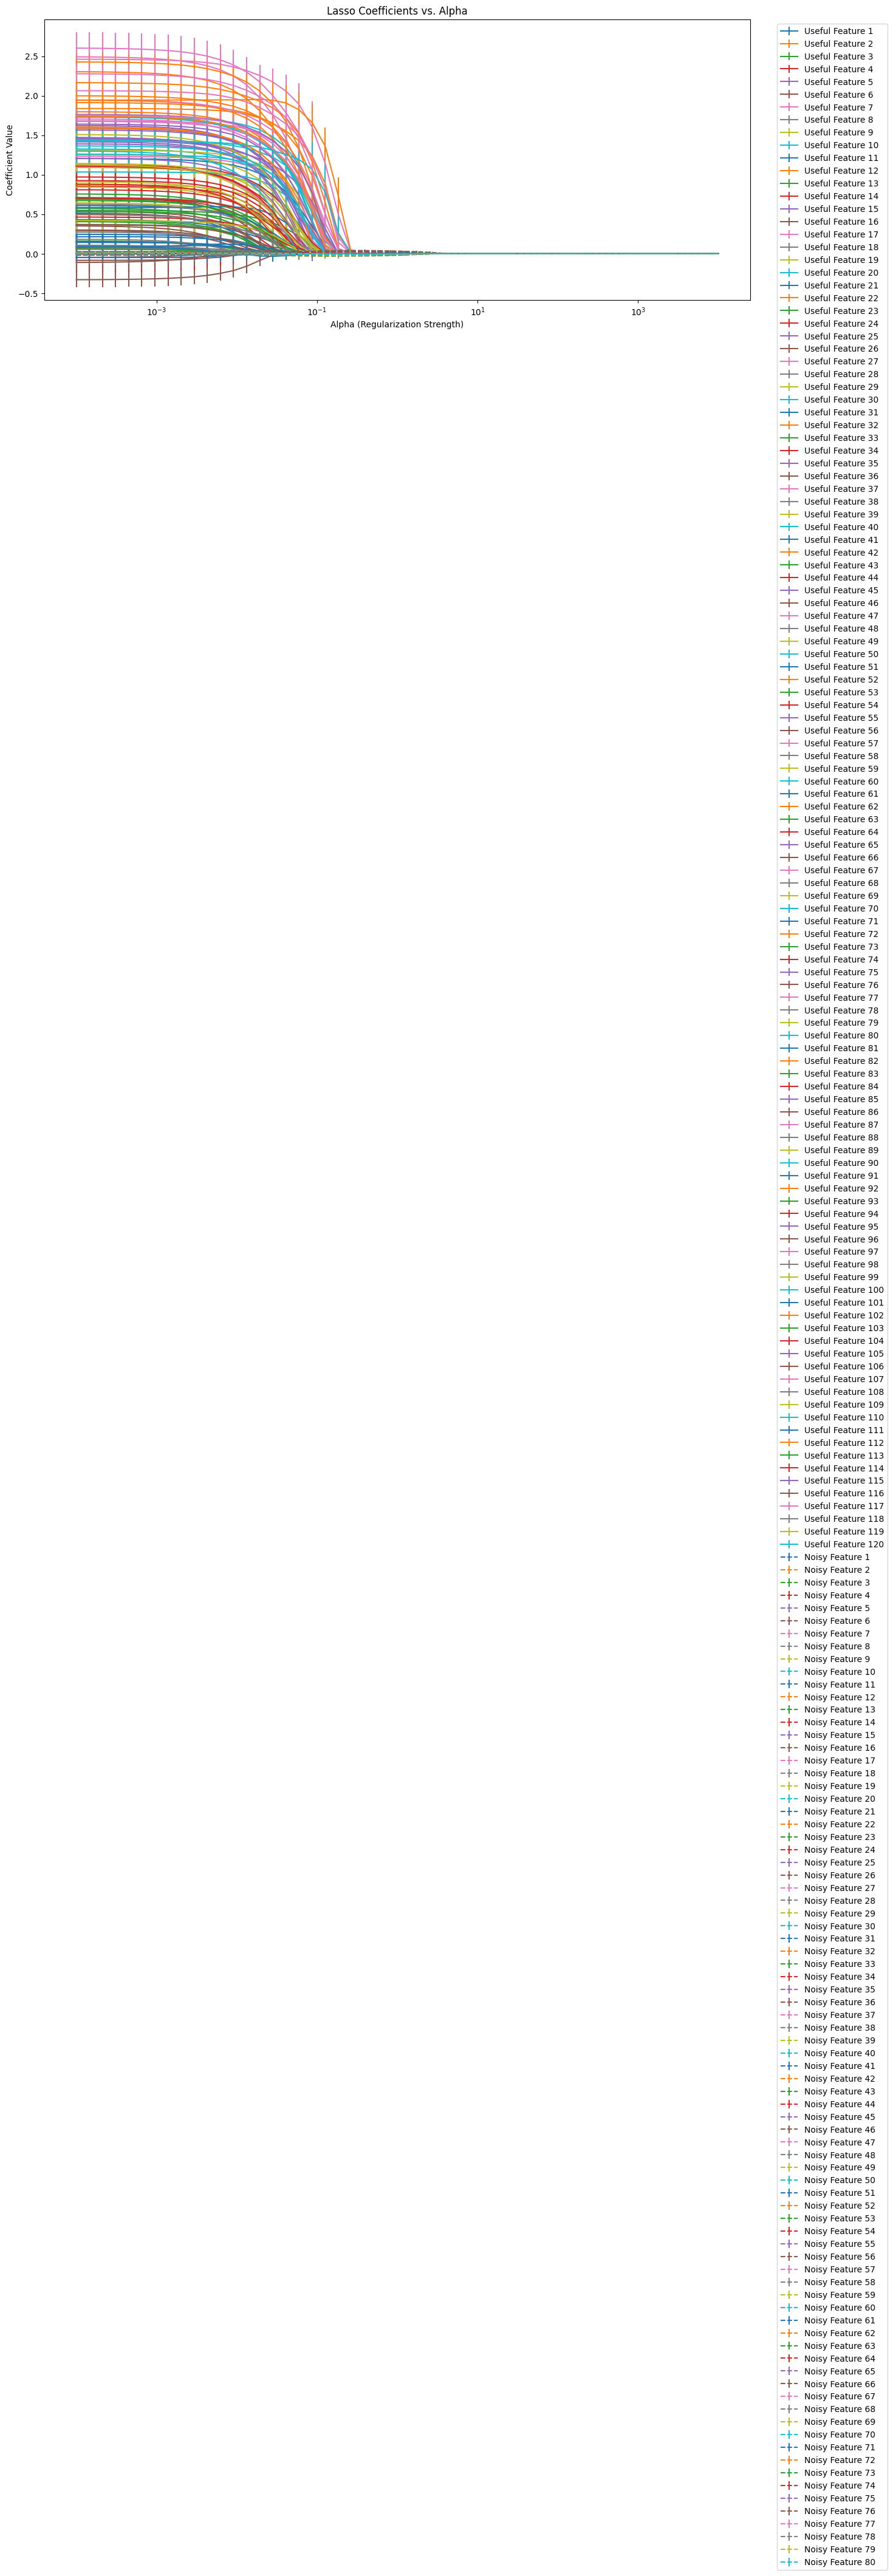

In [111]:
# 5. Graficar los coeficientes
plot_coefficients(alphas, np.array(coeffs_mean), np.array(coeffs_std), n_useful)

In [ ]:
# 7. Display Table
df = display_error_table(alphas, train_errors, train_stds, val_errors, val_stds)
df

,Alpha,Train Error,Train Error Std,Validation Error,Validation Error Std
0,0.000100,3.895417,0.060337,4.252901,0.249835
1,0.000146,3.895420,0.060337,4.252802,0.249734
2,0.000212,3.895426,0.060337,4.252660,0.249585
3,0.000309,3.895439,0.060337,4.252457,0.249370
4,0.000450,3.895467,0.060337,4.252166,0.249061
5,0.000655,3.895527,0.060337,4.251769,0.248605
6,0.000954,3.895653,0.060337,4.251234,0.247940
7,0.001389,3.895920,0.060337,4.250550,0.246969
8,0.002024,3.896487,0.060338,4.249752,0.245552
9,0.002947,3.897673,0.060325,4.248853,0.243608
